# Biostat 257 Homework 2

**Due Apr 29 @ 11:59PM**

Ami Sheth

In [1]:
versioninfo()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.5.0)
  CPU: Intel(R) Core(TM) i5-4260U CPU @ 1.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, haswell)


In [2]:
# load libraries
# import Pkg; Pkg.add("Images")
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, Random

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an analog of principal components and vector quantization with applications in data compression and clustering. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
	L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Lee and Seung suggest an iterative algorithm with multiplicative updates
$$
v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that will drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates iteration number. In following questions, efficiency (both speed and memory) will be the most important criterion when grading this problem.

### Q1.1 Develop code

Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.

In [75]:
function nnmf(
    X       :: Matrix{T}, 
    r       :: Integer;
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: Matrix{T} = rand(T, size(X, 1), r),
    W       :: Matrix{T} = rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    # initialization 
    V = V
    W = W
    n = size(X, 2)
    m = size(X, 1)
    # evaluate obj at starting point
    for j = 1:n, k = 1:r, i = 1:m
        obj = sum((X[i, j] - dot(V[i, k], W[k, j]))^2)
    end
    niter = maxiter
    # loop
    for iter in 1:maxiter
        # update V
        for j = 1:n, k = 1:r, i = 1:m
            b_ij = dot(V[i, k], W[k, j])
            V[i, k] = V[i, k] * (sum(X[i, j] * W[k, j]))/(sum(b_ij * W[k, j]))
        end
        # update W
        for i = 1:m, k = 1:r, j = 1:n
            b_ij_2 = dot(V[i, k], W[k, j])
            W[k, j] = W[k, j] * (sum(X[i, j] * V[i, k]))/(sum(b_ij_2 * V[i, k]))
        end
        # update obj
        objold = obj
        for j = 1:n, k = 1:r, i = 1:m
            obj = sum((X[i, j] - dot(V[i, k], W[k, j]))^2)
        end
        # check convergence
        if abs(obj - objold) ≤ tolfun * (abs(objold) + 1)
            niter = iter
            break
        end
    end
    # Output
    V, W, obj, niter
end

nnmf (generic function with 1 method)

In [54]:
# evaluate obj
function loss(V, W, X, r, m, n, L)
    for j = 1:n, k = 1:r, i = 1:m
        L = sum((X[i, j] - dot(V[i, k], W[k, j]))^2)
    end
    L
end

loss (generic function with 2 methods)

In [52]:
V = rand(5, 2)
W = rand(2, 7)
X = rand(5, 7)
r = 2
m = 5
n = 7
L = 0

0

In [49]:
test = 0
for j = 1:n, k = 1:r, i = 1:m
    test = dot(V[i, k], W[k, j])
end
test

0.37175998583076253

In [55]:
loss(V, W, X, r, m, n, L)

0.014646073559691499

In [36]:
@benchmark loss($V, $W, $X, $r, $m, $n, $L)

BenchmarkTools.Trial: 10000 samples with 968 evaluations.
 Range (min … max):  79.724 ns …  1.107 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     79.865 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   84.438 ns ± 18.248 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █        ▄               ▁                                  ▁
  █▅█▇▄█▇▂▄█▇██▇▇▆██▇▆▆█▅▅▆█▆▆▆▅▅▇▅▄▄▄▇▅▄▄▄▅▃▆▄▅▃▃▄▂▃▄▄▃▄▄▄▄▄ █
  79.7 ns      Histogram: log(frequency) by time       144 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [27]:
# update V
function update_V(V, W, X, r, m, n)
    for j = 1:n, k = 1:r, i = 1:m
        b_ij = dot(V[i, k], W[k, j])
        V[i, k] = V[i, k] * (sum(X[i, j] * W[k, j]))/(sum(b_ij * W[k, j]))
        end
    V
end

update_V (generic function with 1 method)

In [16]:
V = rand(5, 2)

5×2 Matrix{Float64}:
 0.134383  0.0489041
 0.736     0.980451
 0.968846  0.721544
 0.930031  0.248886
 0.404256  0.967439

In [17]:
V[1, 1] = 1

1

In [18]:
V

5×2 Matrix{Float64}:
 1.0       0.0489041
 0.736     0.980451
 0.968846  0.721544
 0.930031  0.248886
 0.404256  0.967439

In [19]:
update_V(V, W, X, r, m, n)

5×2 Matrix{Float64}:
 0.544927    9.56691
 0.0844555   1.48273
 0.854968   15.0101
 0.530526    9.31408
 1.4356     25.2038

In [26]:
@benchmark update_V($V, $W, $X, $r, $m, $n)

BenchmarkTools.Trial: 10000 samples with 198 evaluations.
 Range (min … max):  442.854 ns …   4.162 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     443.328 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   483.279 ns ± 104.764 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █       ▅▁▁▂  ▁   ▁         ▁   ▁                             ▁
  ███▄▁█▅██████████████▇██▇▇▆████▇█▆▆▇▇▇█▆▇▅▆▅▅▅▆▅▆▅▅▅▅▅▅▅▄▁▅▅▆ █
  443 ns        Histogram: log(frequency) by time        856 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [48]:
function update_W(V, W, X, r, m, n)
    for i = 1:m, k = 1:r, j = 1:n
        b_ij_2 = dot(V[i, k], W[k, j])
        W[k, j] = W[k, j] * (sum(X[i, j] * V[i, k]))/(sum(b_ij_2 * V[i, k]))
        end
    W
end

update_W (generic function with 1 method)

In [35]:
W = rand(2, 7)

2×7 Matrix{Float64}:
 0.524283  0.22223   0.355988  0.88715  0.29302   0.15976   0.414871
 0.611111  0.567646  0.250533  0.81062  0.373186  0.581765  0.467951

In [36]:
W[1, 1] = 1

1

In [37]:
W

2×7 Matrix{Float64}:
 1.0       0.22223   0.355988  0.88715  0.29302   0.15976   0.414871
 0.611111  0.567646  0.250533  0.81062  0.373186  0.581765  0.467951

In [38]:
update_W(V, W, X, r, m, n)

2×7 Matrix{Float64}:
 0.182841   0.656393   0.309252   0.298407   0.150264  0.546874   0.625323
 0.0104146  0.0373879  0.0176149  0.0169971  0.008559  0.0311497  0.0356182

In [49]:
@benchmark update_W($V, $W, $X, $r, $m, $n)

BenchmarkTools.Trial: 10000 samples with 198 evaluations.
 Range (min … max):  433.460 ns …  2.202 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     434.071 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   461.606 ns ± 72.387 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁    ▁   ▄▂▁ ▁   ▁                                          ▁
  ███▇▃▂█▂▄▆███▇█▇▆▆█▆▅▅▅█▅▅▆▅█▆▅▅▆▄█▄▆▆▄▄█▆▄▅▇▇▆▄▆▄▅▄▄▅▄▄▄▅▃▅ █
  433 ns        Histogram: log(frequency) by time       752 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [18]:
function update_VW(V, W, X, r, m, n)
    for j = 1:n, k = 1:r, i = 1:m
        b_ij = dot(V[i, k], W[k, j])
        V[i, k] = V[i, k] * (sum(X[i, j] * W[k, j]))/(sum(b_ij * W[k, j]))
        end
    for i = 1:m, k = 1:r, j = 1:n
        b_ij_2 = dot(V[i, k], W[k, j])
        W[k, j] = W[k, j] * (sum(X[i, j] * V[i, k]))/(sum(b_ij_2 * V[i, k]))
        end
    
    V, W
end

update_VW (generic function with 1 method)

In [66]:
V = rand(5, 2)
W = rand(2, 7)
X = rand(5, 7)
L = 0

0

In [67]:
loss(V, W, X, 2, 5, 7, L)

0.0016439973673529839

In [68]:
V, W = update_VW(V, W, X, 2, 5, 7)

([0.4614691198463799 0.5215256234451938; 0.941719611732567 1.0642768638189426; … ; 0.46943754764226914 0.5305310781883251; 0.3262562942695343 0.3687159334268773], [2.429824807282397 2.253743928995086 … 2.842607337330828 0.6797641661546319; 2.150017304596237 1.9942130942714449 … 2.5152656879279314 0.6014856362881112])

In [31]:
V1

5×2 Matrix{Float64}:
 0.739377  0.413465
 9.81898   5.49085
 2.38667   1.33464
 3.70685   2.0729
 3.92261   2.19355

In [69]:
loss(V, W, X, 2, 5, 7, L)

7.703719777548943e-34

In [72]:
obj = for j = 1:n, k = 1:r, i = 1:m
        L = sum((X[i, j] - dot(V[i, k], W[k, j]))^2)
end

In [74]:
L

7.703719777548943e-34

### Q1.2 Data

Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  

Read in the [`nnmf-2429-by-361-face.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2022spring/master/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm`](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/#Delimited-Files) function, and display a couple sample images, e.g., using the [Images.jl](https://juliaimages.org/stable/) package.

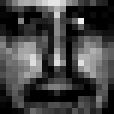

In [76]:
X = readdlm("nnmf-2429-by-361-face.txt")
colorview(Gray, reshape(X[1, :], 19, 19))

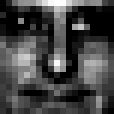

In [5]:
colorview(Gray, reshape(X[5, :], 19, 19))

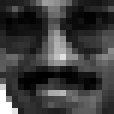

In [17]:
colorview(Gray, reshape(X[20, :], 19, 19))

### Q1.3 Correctness and efficiency

Report the run times, using `@time`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2022spring/master/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2022spring/master/hw/hw2/W0.txt)) and stopping criterion
$$
\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

**Hint**: When I run the following code using my own implementation of `nnmf`
```julia
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    @time V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
    println("obj=$obj, niter=$niter")
end
```
the output is
```
r=10
  1.047598 seconds (20 allocations: 6.904 MiB)
obj=11730.38800985483, niter=239
r=20
  1.913147 seconds (20 allocations: 7.120 MiB)
obj=8497.222317850326, niter=394
r=30
  2.434662 seconds (20 allocations: 7.336 MiB)
obj=6621.627345486279, niter=482
r=40
  3.424469 seconds (22 allocations: 7.554 MiB)
obj=5256.663870563529, niter=581
r=50
  4.480342 seconds (23 allocations: 7.774 MiB)
obj=4430.201581697291, niter=698
```
Since my laptop is about 6-7 years old, I expect to see your run time shorter than mine. Your memory allocation should be less or equal to mine.

In [77]:
V0full = readdlm("V0.txt")
W0full = readdlm("W0.txt")

50×361 Matrix{Float64}:
 0.5634    0.32048   0.067202   0.25107   …  0.4476     0.12656   0.13688
 0.71473   0.25423   0.084735   0.84327      0.20947    0.32729   0.43787
 0.046351  0.041688  0.79152    0.8962       0.6786     0.17112   0.83691
 0.76991   0.13366   0.0061026  0.70588      0.4457     0.012722  0.64244
 0.56335   0.35408   0.62697    0.94923      0.073816   0.62934   0.58596
 0.13659   0.82449   0.17183    0.051802  …  0.87725    0.86247   0.45418
 0.2326    0.92296   0.73855    0.35246      0.015108   0.68424   0.15457
 0.95628   0.97221   0.94922    0.59106      0.49038    0.52232   0.4399
 0.82876   0.33257   0.95808    0.11028      0.66812    0.69979   0.57679
 0.33585   0.59454   0.75948    0.26544      0.34689    0.071471  0.020196
 0.87571   0.83349   0.83207    0.57283   …  0.34609    0.22545   0.2295
 0.27631   0.10171   0.4809     0.10614      0.0039955  0.92647   0.27393
 0.914     0.45783   0.32193    0.65607      0.1204     0.29447   0.88988
 ⋮             

In [78]:
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    @time V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
    println("obj=$obj, niter=$niter")
end

r=10


LoadError: MethodError: no method matching -(::Nothing, ::Nothing)
[0mClosest candidates are:
[0m  -([91m::ChainRulesCore.AbstractThunk[39m, ::Any) at ~/.julia/packages/ChainRulesCore/RbX5a/src/tangent_types/thunks.jl:30
[0m  -([91m::ChainRulesCore.ZeroTangent[39m, ::Any) at ~/.julia/packages/ChainRulesCore/RbX5a/src/tangent_arithmetic.jl:101
[0m  -([91m::ChainRulesCore.NotImplemented[39m, ::Any) at ~/.julia/packages/ChainRulesCore/RbX5a/src/tangent_arithmetic.jl:49
[0m  ...

### Q1.4 Non-uniqueness

Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

### Q1.5 Fixed point

For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

### Q1.6 Interpret NNMF result

Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

### Q1.7 GPU (optional)

Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in Q1.3.

## Q2. Estimating Kinship Matrix

Consider the numerical task of estimating an $n \times n$ kinship matrix $\Phi$ from an $n \times m$ genotype matrix $\mathbf{G}$. Here $n$ is the number of individuals and $m$ is the number of genetic markers. [Lange et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6763373/) derived a method of moment estimator of form
$$
    \widehat \Phi_{ij} = \frac{e_{ij} - \sum_{k=1}^m [p_k^2 + (1 - p_k)^2]}{m - \sum_{k=1}^m [p_k^2 + (1 - p_k)^2]}, \quad 1 \le i, j \le n,
$$
where
$$
\begin{eqnarray*}
    e_{ij} &=& \frac{1}{4} \sum_{k=1}^m [g_{ik} g_{jk} + (2 - g_{ik})(2 - g_{jk})] \\
    p_k &=& \frac {1}{2n} \sum_{i=1}^n g_{ik}.
\end{eqnarray*}
$$

### Q2.1 Develop code

Write a function that takes a matrix `G` as input and outputs the method of moment estimator. 
Make your function as efficient (both speed and memory) as possible.    

In [ ]:
function kinship(G::Matrix{T}) where T <: AbstractFloat
    n, m = size(G)
    # TODO: your code here
    Φ = zeros(n, m)
    # output
    Φ
end

### Q2.2 Correctness

First let's make sure our function yields correct answer. Run your function on a fake genotype matrix

In [ ]:
# generate a fake genotype matrix with entries {0, 1, 2}
Random.seed!(257)
G = rand(0.0:2.0, 1000, 10000)
Φ = kinship(G)

Compare the upper left $5 \times 5$ block to what I got using my implementation

```julia
Φ[1:5, 1:5]
```

```
5×5 Matrix{Float64}:
  0.673584     -0.000762864  -0.00266412   0.00343992   0.00293959
 -0.000762864   0.665178     -0.0101691   -0.0110697    0.00223912
 -0.00266412   -0.0101691     0.665078     0.0102444    0.00253932
  0.00343992   -0.0110697     0.0102444    0.66768     -0.0083679
  0.00293959    0.00223912    0.00253932  -0.0083679    0.663777
```

### Q2.3 Efficiency

In a typical genetic data set, $n$ is at order of $10^3 \sim 10^6$ and $m$ is at order of $10^6 \sim 10^7$. Benchmark your function using the smaller data set $G$ generated in Q2.2. Efficiency (both speed and memory) will be the most important criterion when grading this question.

In [ ]:
# benchmark
@btime kinship($G)

**Hint**: I got `@btime` output
```
82.144 ms (3 allocations: 7.64 MiB)
```